# Problem 2

## Data Import
First, download the movielens (small) [dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) as `pandas.DataFrame` objects.

In [138]:
import pandas as pd

# path = "Misc_files/movielens_data/ml-latest-small/"
path = ""

# load movies and ratings DataFrames
movies = pd.read_csv(path+"movies.csv", header=0)
ratings = pd.read_csv(path+"ratings.csv", header=0)

In [139]:
# For the debugging

movies = movies[:1000]

We can then use the `head()` method to see the raw format of these `DataFrame` objects.

In [140]:
n_movies = len(movies)

print(f"Number of Unique Movies: {n_movies}")
movies.head()

Number of Unique Movies: 1000


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [141]:
n_ratings = len(ratings)
n_users = ratings.userId.nunique()
n_rated_movies = ratings.movieId.nunique()

print(f"Number of Ratings: {n_ratings}\nNumber of Users: {n_users}\nNumber of Unique Rated Movies: {n_rated_movies}")
ratings.head()

Number of Ratings: 100836
Number of Users: 610
Number of Unique Rated Movies: 9724


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Upon inspection of the raw data we note that of the 9,742 movies in the `movies` DataFrame, only 9,724 movies have been rated.

## Preprocessing

### Embedding Matrix $X$
To obtain the concurrent number of likes $X_{i,j}$ we must first binary encode (`0` or `1`) each `"rating"` in the `ratings` DataFrame. Let us encode the value of liking a movie for each review as such

$$ \text{Liked}(\text{Rating}) =
    \begin{cases}
        1 & \text{if Rating}\geq 4\\
        0 & \text{otherwise}
    \end{cases}$$

and store these values in a new `"liked"` column. We can subsequently drop the unnecessary `rating` and `timestamp` columns after this process.

In [142]:
import numpy as np

# create liked column
ratings["liked"] = np.where(ratings["rating"] >= 4, 1, 0)

# drop columns
ratings.drop(["rating", "timestamp"], axis=1, inplace=True)

We next create the `movie_ratings` DataFrame by joing the `movies` and `ratings` DataFrames. Setting the `merge` method parameter `how="left"` ensures that the original number of movies, 9,742, are maintained after the join.

In [143]:
# left join on movieId
movie_ratings = pd.merge(movies, ratings, how="left", on="movieId").reset_index()

A user-likes interaction matrix can then be constructed using the `pivot_table` method, whose rows correspond to the number of unique users `n_users` and columns correspond to the number of unique movies `n_movies` from the original data. This results in a sparse matrix whose rows summarize each users liked movies.

In [144]:
# pivot table on userId
user_likes = movie_ratings.pivot_table(values="liked", index="userId", columns="movieId", dropna=False, fill_value=0)

user_likes

movieId,1,2,3,4,5,6,7,8,9,10,...,1291,1292,1293,1295,1296,1297,1298,1299,1300,1301
userId,,,,,,,,,,,,,,,,,,,,,
1.0,1,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5.0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606.0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
607.0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
608.0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


Embedding matrix $X$ can now be constructed as the inner (dot) product of the transpose of `user_likes ` and itself. Element $X_{ij} \in X$ corresponds to the number of users that like both movie $i$ and $j$.

In [145]:
# convert to numpy ndarray for dot product computation
user_likes_array = user_likes.to_numpy()

# create X
X_embedding = np.dot(user_likes_array.T, user_likes_array)

# fill diagonals of X with zeros
np.fill_diagonal(X_embedding, 0)

# display as DataFrame for clarity
X_display = pd.DataFrame(X_embedding, index=movies.movieId, columns = movies.movieId)

X_display

movieId,1,2,3,4,5,6,7,8,9,10,...,1291,1292,1293,1295,1296,1297,1298,1299,1300,1301
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,21,11,0,7,27,7,1,4,19,...,47,7,10,2,6,8,5,12,3,4
2,21,0,5,0,4,8,6,0,0,9,...,16,0,2,1,1,2,1,1,1,2
3,11,5,0,0,4,4,5,1,2,3,...,3,1,0,0,0,2,3,2,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,7,4,4,0,0,3,4,1,1,2,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,8,2,2,0,0,2,1,0,0,2,...,9,1,1,0,2,0,3,4,1,0
1298,5,1,3,0,0,6,1,0,0,0,...,5,0,1,0,0,3,0,1,0,1
1299,12,1,2,0,0,4,0,0,0,1,...,6,7,6,2,5,4,1,0,3,1


## Model Architecture

With preprocessing completed, we convert embedding $X$ into a `torch` tensor object and construct cost function $c$.

In [155]:
import torch
from torch import mps

# make torch deterministic for reproducibility
torch.manual_seed(576)

# set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

X = torch.tensor(X_embedding, dtype = torch.float32)

We implement the below cost function:
$$c(v_1,\ldots, v_M)=\sum_{i=1}^M\sum_{j=1}^M 1_{[i\neq j]}(v_i^T v_j-X_{i,j})^2$$
by creating a superclass of the `torch` `nn.Module` class.

In [156]:
import torch.nn as nn

class cost_function(nn.Module):
    def __init__(self):
        super().__init__()

    @ classmethod
    def forward(self, v, X):
        # perform main cost function
        costs = ((1 - torch.eye(n_movies)) * (torch.mm(v.t(), v) - X)**2).sum()

        return costs

In [157]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def train(model, v, X, optimizer, n_epochs=100, verbose=10):
    costs = []  # Create a list to store the cost values at each epoch

    for epoch in tqdm(range(n_epochs)):
        # forward pass
        cost = model.forward(v, X)

        # backward pass
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        costs.append(cost.item())  # Append the cost value to the list
        if epoch % verbose == 0:
            print(f"Epoch: {epoch}\tCost: {cost:.5f}")

    return costs


# def train(model, v, X, optimizer, n_epochs=100, verbose=10):
#     costs = []  # Create a list to store the cost values at each epoch

#     for epoch in tqdm(range(n_epochs)):
#         # Clone the current state of 'v'
#         v_clone = v.clone().detach().requires_grad_(True)

#         # Forward pass
#         cost = model.forward(v_clone, X)

#         # Backward pass
#         optimizer.zero_grad()
#         cost.backward()
#         optimizer.step()

#         costs.append(cost.item())  # Append the cost value to the list
#         if epoch % verbose == 0:
#             print(f"Epoch: {epoch}\tCost: {cost:.5f}")

#     return costs, v_clone


Need to evaluate model on multiple hyper parameters:
different learning rates different optimizers – Adam and SGD

We need two different plots for costs/epoch iterations, one for Adam and one for SGD.

In [158]:
def plot_cost_history(costs, optimizer_name, lr):
    plt.figure()
    plt.plot(range(len(costs)), costs, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Cost')
    plt.title(f'{optimizer_name} Cost vs. Epoch, LR={lr}')
    plt.grid(True)
    plt.show()

def train_loop(optimizer_name, lr):
    import torch.optim as optim

    v = torch.normal(mean=0, std=0.5, size=(n_movies, n_movies), requires_grad=True)
    model = cost_function()
    model.to(device)

    if optimizer_name == 'Adam':
        optimizer = optim.Adam([v], lr)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD([v], lr)
    history = train(model, v, X, optimizer, 100)

    # Plot the cost history
    plot_cost_history(history, optimizer_name, lr)

    return history

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0	Cost: 75356928.00000
Epoch: 10	Cost: 271268768.00000
Epoch: 20	Cost: 28331170.00000
Epoch: 30	Cost: 15065090.00000
Epoch: 40	Cost: 4460538.00000
Epoch: 50	Cost: 1516202.75000
Epoch: 60	Cost: 626911.25000
Epoch: 70	Cost: 309572.06250
Epoch: 80	Cost: 170583.59375
Epoch: 90	Cost: 99290.21875


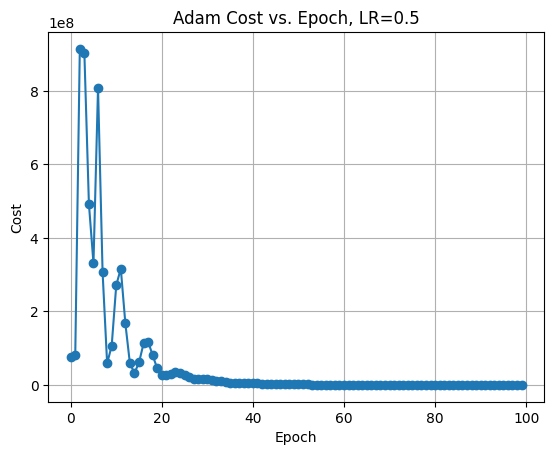

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0	Cost: 75676264.00000
Epoch: 10	Cost: 3517158.00000
Epoch: 20	Cost: 1097652.00000
Epoch: 30	Cost: 347324.65625
Epoch: 40	Cost: 120808.46875
Epoch: 50	Cost: 44342.86328
Epoch: 60	Cost: 16848.36328
Epoch: 70	Cost: 6608.67285
Epoch: 80	Cost: 2722.95215
Epoch: 90	Cost: 1196.32178


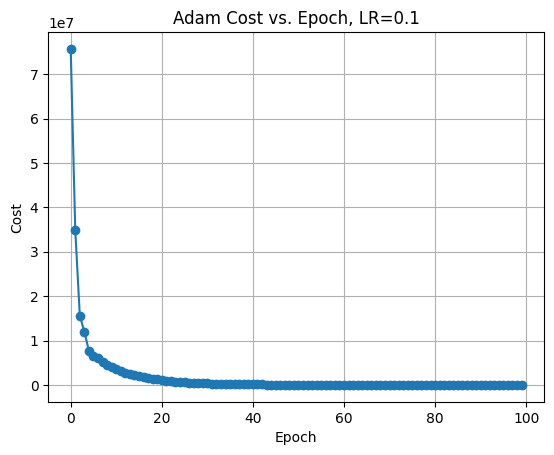

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0	Cost: 75586944.00000
Epoch: 10	Cost: 33602808.00000
Epoch: 20	Cost: 14604181.00000
Epoch: 30	Cost: 7413984.50000
Epoch: 40	Cost: 4261894.00000
Epoch: 50	Cost: 2627574.75000
Epoch: 60	Cost: 1715857.00000
Epoch: 70	Cost: 1164619.37500
Epoch: 80	Cost: 810332.81250
Epoch: 90	Cost: 571600.12500


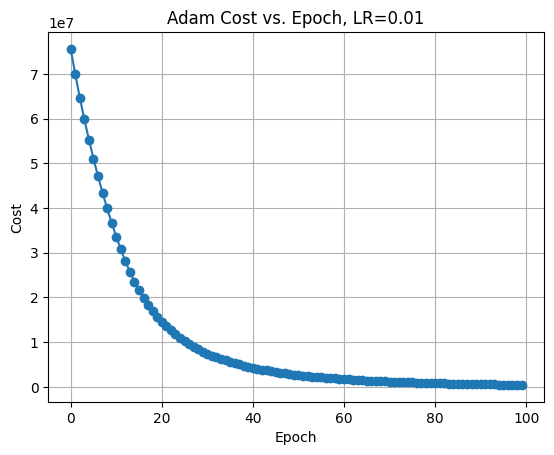

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0	Cost: 75943064.00000
Epoch: 10	Cost: 37139104.00000
Epoch: 20	Cost: 21927822.00000
Epoch: 30	Cost: 15628822.00000
Epoch: 40	Cost: 11864572.00000
Epoch: 50	Cost: 9387347.00000
Epoch: 60	Cost: 7653410.00000
Epoch: 70	Cost: 6382516.00000
Epoch: 80	Cost: 5417413.00000
Epoch: 90	Cost: 4663786.00000


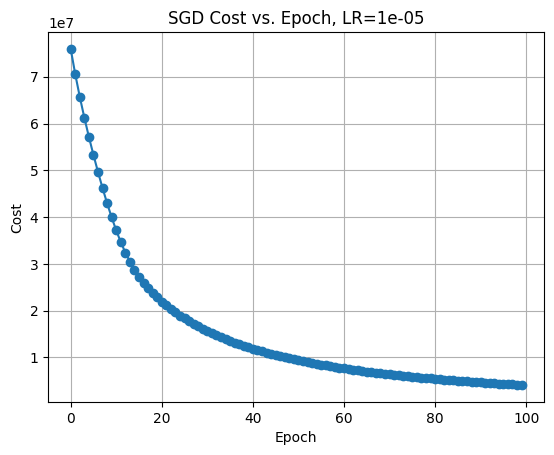

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0	Cost: 75850960.00000
Epoch: 10	Cost: 70615488.00000
Epoch: 20	Cost: 65878072.00000
Epoch: 30	Cost: 61525912.00000
Epoch: 40	Cost: 57473012.00000
Epoch: 50	Cost: 53658244.00000
Epoch: 60	Cost: 50044884.00000
Epoch: 70	Cost: 46619924.00000
Epoch: 80	Cost: 43391016.00000
Epoch: 90	Cost: 40380120.00000


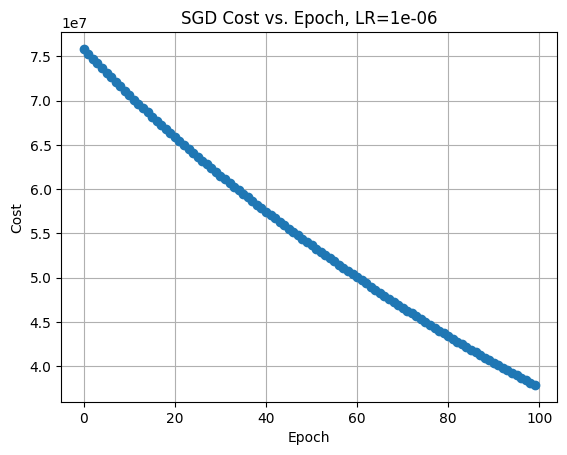

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0	Cost: 75533984.00000
Epoch: 10	Cost: 74984864.00000
Epoch: 20	Cost: 74441792.00000
Epoch: 30	Cost: 73904624.00000
Epoch: 40	Cost: 73373192.00000
Epoch: 50	Cost: 72847360.00000
Epoch: 60	Cost: 72327000.00000
Epoch: 70	Cost: 71811960.00000
Epoch: 80	Cost: 71302104.00000
Epoch: 90	Cost: 70797312.00000


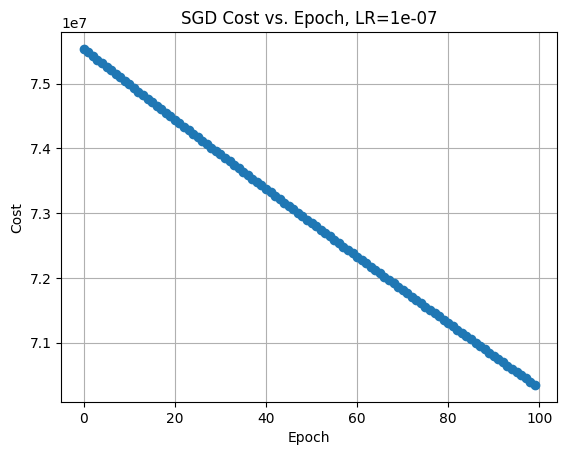

In [159]:
history1 = train_loop(optimizer_name='Adam', lr=0.5)
history2 = train_loop(optimizer_name='Adam', lr=1e-1)
history3 = train_loop(optimizer_name='Adam', lr=1e-2)

history4 = train_loop(optimizer_name='SGD', lr=1e-5)
history5 = train_loop(optimizer_name='SGD', lr=1e-6)
history6 = train_loop(optimizer_name='SGD', lr=1e-7)

Need to complete Problem 2, recommendation system and comparison between optimizers.

In [134]:
movies["title"]

0                                 Toy Story (1995)
1                                   Jumanji (1995)
2                          Grumpier Old Men (1995)
3                         Waiting to Exhale (1995)
4               Father of the Bride Part II (1995)
                          ...                     
995                             Real Genius (1985)
996                    Pink Floyd: The Wall (1982)
997                     Killing Fields, The (1984)
998    My Life as a Dog (Mitt liv som hund) (1985)
999                        Forbidden Planet (1956)
Name: title, Length: 1000, dtype: object